In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define data path using raw string or double backslashes
data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\raw'

# File names
files = {
    'demo': 'df_final_demo.csv',
    'web_pt_1': 'df_final_web_data_pt_1.csv',
    'web_pt_2': 'df_final_web_data_pt_2.csv',
    'experiment': 'df_final_experiment_clients.csv'
}

# Try loading the datasets
try:
    df_final_demo = pd.read_csv(os.path.join(data_path, files['demo']))
    df_final_web_data_pt_1 = pd.read_csv(os.path.join(data_path, files['web_pt_1']))
    df_final_web_data_pt_2 = pd.read_csv(os.path.join(data_path, files['web_pt_2']))
    df_final_experiment_clients = pd.read_csv(os.path.join(data_path, files['experiment']))
    print("All datasets loaded successfully!")

except FileNotFoundError as e:
    print(f"Error loading file: {e}")
    exit()

# Merge web data
#df_final_web_data = pd.concat([df_final_web_data_pt_1, df_final_web_data_pt_2], ignore_index=True)
#print("\nWeb data parts merged.")

All datasets loaded successfully!


In [48]:
def quick_data_report(df, file_path="df_name.txt", max_unique=50):
    with open(file_path, "w", encoding="utf-8") as f:
        def p(*args): print(*args, file=f)

        p("=== Shape (rows, columns) ===")
        p(df.shape)

        p("\n=== Column Names ===")
        p(df.columns.tolist())

        p("\n=== Data Types ===")
        p(df.dtypes)

        p("\n=== Missing Values (per column) ===")
        p(df.isnull().sum())

        p("\n=== Duplicate Rows ===")
        p(df.duplicated().sum())

        p("\n=== Unique Values (per column) ===")
        p(df.nunique())

        p("\n=== DataFrame Info ===")
        df.info(buf=f)

        p("\n=== Descriptive Statistics (including non-numeric) ===")
        p(df.describe(include='all'))

        p("\n=== First 5 Rows ===")
        p(df.head())

        p("\n=== Last 5 Rows ===")
        p(df.tail())

        p("\n=== Random Sample of 5 Rows ===")
        p(df.sample(5))

        p("\n=== Value Counts (for columns with 50 or fewer unique values) ===")
        for col in df.columns:
            if df[col].nunique() <= max_unique:
                p(f"\n--- {col} ---")
                p(df[col].value_counts())


In [51]:
quick_data_report(df_final_demo, file_path="report_df_final_demo.txt")

quick_data_report(df_final_web_data_pt_1, file_path="report_df_final_web_data_pt_1.txt")

quick_data_report(df_final_web_data_pt_2, file_path="report_df_final_web_data_pt_2.txt")

quick_data_report(df_final_experiment_clients, file_path="report_df_final_experiment_clients.txt")


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

print("--- Starting Data Cleaning and Initial EDA ---")

### --- Data Cleaning Steps ---

#### **1. Concatenate Web Data Parts** ####
# Requirement: Combine the two parts of the web interaction data into a single DataFrame.
# Goal: Create a unified dataset for all web events.
print("\n#### 1. Concatenating df_final_web_data_pt_1 and df_final_web_data_pt_2 ####")
print("Initial rows in df_final_web_data_pt_1:", len(df_final_web_data_pt_1))
print("Initial rows in df_final_web_data_pt_2:", len(df_final_web_data_pt_2))

df_final_web_data = pd.concat([df_final_web_data_pt_1, df_final_web_data_pt_2], ignore_index=True)

print(f"Combined df_final_web_data now has {len(df_final_web_data)} entries.")
print("Proof (head of combined web data):")
print(df_final_web_data.head())
print("\nProof (info of combined web data):")
print(df_final_web_data.info())


#### **2. Convert 'date_time' to Datetime Objects and Sort Web Data** ####
# Requirement: Convert the 'date_time' column from object (string) to datetime objects for time-based calculations.
# Requirement: Sort the web data by client_id, visit_id, and date_time to ensure correct sequential processing of steps.
# Goal: Enable accurate calculation of time spent and detection of backward movements.
print("\n#### 2. Converting 'date_time' to datetime objects and sorting web data ####")

print("Original 'date_time' Dtype:", df_final_web_data['date_time'].dtype)
df_final_web_data['date_time'] = pd.to_datetime(df_final_web_data['date_time'])
print("New 'date_time' Dtype:", df_final_web_data['date_time'].dtype)

print("Sorting df_final_web_data by client_id, visit_id, and date_time...")
df_final_web_data = df_final_web_data.sort_values(by=['client_id', 'visit_id', 'date_time']).reset_index(drop=True)
print("Web data sorted successfully.")

print("\nProof (head of sorted web data, showing date_time type and order):")
print(df_final_web_data.head())


#### **3. Handle Missing Values in `df_final_demo`** ####
# Requirement: Identify, quantify, and address missing values within the `df_final_demo` DataFrame.
# Goal: Ensure data integrity for demographic analysis by removing incomplete client records.

print("\n#### 3. Handling missing values in df_final_demo ####")

# Step 3.1: Identify and Quantify Missing Values
print("\nStep 3.1: Identifying and Quantifying Missing Values (before cleaning)")
missing_values_count = df_final_demo.isnull().sum()
print("Counts of missing values per column:")
print(missing_values_count[missing_values_count > 0])

missing_values_percentage = (df_final_demo.isnull().sum() / len(df_final_demo)) * 100
print("\nPercentage of missing values per column:")
print(missing_values_percentage[missing_values_percentage > 0])

print(f"\nTotal rows in df_final_demo before dropping NaNs: {len(df_final_demo)}")

# Step 3.2: Choose and Implement Strategy (Dropping Rows)
# Observation: Given the very small percentage of missing values (<0.03%) and that they are concentrated
# across multiple columns for the same few rows, dropping these rows is the most appropriate strategy.
initial_demo_rows = len(df_final_demo)
df_final_demo.dropna(inplace=True)

print(f"Number of rows dropped: {initial_demo_rows - len(df_final_demo)}")


# Step 3.3: Proof of Resolution
print("\nStep 3.3: Proof of Resolution (after cleaning)")
print("Missing values in df_final_demo (after cleaning):")
print(df_final_demo.isnull().sum())
print(f"Shape of df_final_demo after cleaning: {df_final_demo.shape}")


#### **4. Clean 'gendr' Column in `df_final_demo`** ####
# Requirement: Standardize the 'gendr' column to consistent, human-readable labels.
# Goal: Improve data quality and readability for demographic analysis.

print("\n#### 4. Cleaning 'gendr' column in df_final_demo ####")

print("Unique genders before cleaning:", df_final_demo['gendr'].unique())

# change 'M', 'F', 'U' if present.
df_final_demo['gendr'] = df_final_demo['gendr'].replace({'M': 'Male', 'F': 'Female', 'U': 'Unknown'})

print("Unique genders after cleaning:", df_final_demo['gendr'].unique())
print("Proof (value counts after cleaning):")
print(df_final_demo['gendr'].value_counts())


#### **5. Check for and Remove Duplicates Across All DataFrames** ####
# Requirement: Ensure no identical rows exist within each DataFrame that could skew analysis.
# Goal: Maintain data accuracy and prevent double-counting of events or clients.

print("\n#### 5. Checking for and removing duplicates across dataframes ####")

# List of dataframes to check for general row-level duplicates
dataframes_to_check = {
    'df_final_demo': df_final_demo,
    'df_final_web_data': df_final_web_data,
    'df_final_experiment_clients': df_final_experiment_clients
}

for df_name, df_obj in dataframes_to_check.items():
    initial_rows = len(df_obj)
    # For web data, define a specific subset to identify unique events (client, visitor, visit, step, time)
    if df_name == 'df_final_web_data':
        subset_cols = ['client_id', 'visitor_id', 'visit_id', 'process_step', 'date_time']
        df_obj.drop_duplicates(subset=subset_cols, inplace=True)
        print(f"Checking {df_name} for duplicates based on {subset_cols}...")
    else:
        df_obj.drop_duplicates(inplace=True)
        print(f"Checking {df_name} for full row duplicates...")

    if initial_rows - len(df_obj) > 0:
        print(f"  Removed {initial_rows - len(df_obj)} duplicates from {df_name}.")
    else:
        print(f"  No duplicates found in {df_name}.")

    # Update the dataframe in the dictionary for consistency
    dataframes_to_check[df_name] = df_obj

# Re-assign to original variables (if they were not updated in-place, which drop_duplicates does)
df_final_demo = dataframes_to_check['df_final_demo']
df_final_web_data = dataframes_to_check['df_final_web_data']
df_final_experiment_clients = dataframes_to_check['df_final_experiment_clients']

print("\nProof (Final shapes after duplicate removal):")
print(f"df_final_demo shape: {df_final_demo.shape}")
print(f"df_final_web_data shape: {df_final_web_data.shape}")
print(f"df_final_experiment_clients shape: {df_final_experiment_clients.shape}")




--- Starting Data Cleaning and Initial EDA ---

#### 1. Concatenating df_final_web_data_pt_1 and df_final_web_data_pt_2 ####
Initial rows in df_final_web_data_pt_1: 343141
Initial rows in df_final_web_data_pt_2: 412264
Combined df_final_web_data now has 755405 entries.
Proof (head of combined web data):
   client_id            visitor_id                      visit_id process_step        date_time
0    9988021  580560515_7732621733  781255054_21935453173_531117       step_3  4/17/2017 15:27
1    9988021  580560515_7732621733  781255054_21935453173_531117       step_2  4/17/2017 15:26
2    9988021  580560515_7732621733  781255054_21935453173_531117       step_3  4/17/2017 15:19
3    9988021  580560515_7732621733  781255054_21935453173_531117       step_2  4/17/2017 15:19
4    9988021  580560515_7732621733  781255054_21935453173_531117       step_3  4/17/2017 15:18

Proof (info of combined web data):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 755405 entries, 0 to 755404
Data column

In [58]:
### --- Merging Datasets ---
# Requirement: Combine the three distinct datasets (`df_final_demo`, `df_final_web_data`, `df_final_experiment_clients`)
#              into a single, comprehensive DataFrame for unified analysis.
# Goal: Create `df_full_ab_test` which contains all relevant data points (demographics, web events, experiment group)
#       for clients actively participating in the A/B test.

print("\n--- Merging Datasets ---")

# Ensure the 'Variation' column from df_final_experiment_clients is lowercase 'variation'
# to match common Python/Pandas naming conventions and prevent KeyErrors.
if 'Variation' in df_final_experiment_clients.columns:
    df_final_experiment_clients.rename(columns={'Variation': 'variation'}, inplace=True)
    print("Renamed 'Variation' column to 'variation' in df_final_experiment_clients.")
elif 'variation' not in df_final_experiment_clients.columns:
    print("WARNING: 'variation' column not found in df_final_experiment_clients. Please check original data.")


# Step 1: Merge experiment clients with demographics
# Use 'left' merge to keep all clients from the experiment assignment, enriching with their demographic data.
print("\nStep 1: Merging df_final_experiment_clients with df_final_demo on 'client_id'...")
df_merged_clients = pd.merge(df_final_experiment_clients, df_final_demo, on='client_id', how='left')
print(f"df_merged_clients has {len(df_merged_clients)} entries.")
print("Proof (head of df_merged_clients):")
print(df_merged_clients.head())
print("\nProof (Columns in df_merged_clients):", df_merged_clients.columns.tolist()) # Check columns after merge 1
print("\nProof (Null values in df_merged_clients after first merge):")
print(df_merged_clients.isnull().sum())


# Step 2: Merge the combined client data with the full web data
# Use 'left' merge to keep all web interactions, enriching them with client demographics and experiment group.
print("\nStep 2: Merging df_final_web_data with df_merged_clients on 'client_id'...")
df_full = pd.merge(df_final_web_data, df_merged_clients, on='client_id', how='left')
print(f"df_full has {len(df_full)} entries.")
print("Proof (head of df_full):")
print(df_full.head())
print("\nProof (Columns in df_full):", df_full.columns.tolist()) # Check columns after merge 2
print("\nProof (Null values in df_full after second merge):")
print(df_full.isnull().sum())


# Step 3: Filter for A/B Test Participants Only
# Requirement: For the A/B test analysis, focus only on clients explicitly assigned to 'Test' or 'Control' groups.
# Goal: Create `df_full_ab_test` which is the final cleaned and merged dataset for primary analysis.

print("\nStep 3: Filtering df_full to include only 'Test' or 'Control' variations (df_full_ab_test)...")
initial_full_rows = len(df_full)
df_full_ab_test = df_full.dropna(subset=['variation']).copy() # Filter out rows where 'variation' is NaN
print(f"Removed {initial_full_rows - len(df_full_ab_test)} rows where 'variation' was NaN (clients not in experiment).")
print(f"df_full_ab_test now has {len(df_full_ab_test)} entries.")
print("\nProof (Value counts for 'variation' in df_full_ab_test):")
print(df_full_ab_test['variation'].value_counts())
print("\nProof (Null values in df_full_ab_test after final filtering):")
print(df_full_ab_test.isnull().sum())

print("\n--- Data Cleaning and Merging Complete ---")




--- Merging Datasets ---

Step 1: Merging df_final_experiment_clients with df_final_demo on 'client_id'...
df_merged_clients has 70609 entries.
Proof (head of df_merged_clients):
   client_id variation  clnt_tenure_yr  clnt_tenure_mnth  clnt_age    gendr  num_accts        bal  calls_6_mnth  logons_6_mnth
0    9988021      Test             5.0              64.0      79.0  Unknown        2.0  189023.86           1.0            4.0
1    8320017      Test            22.0             274.0      34.5     Male        2.0   36001.90           5.0            8.0
2    4033851   Control            12.0             149.0      63.5     Male        2.0  142642.26           5.0            8.0
3    1982004      Test             6.0              80.0      44.5  Unknown        2.0   30231.76           1.0            4.0
4    9294070   Control             5.0              70.0      29.0  Unknown        2.0   34254.54           0.0            3.0

Proof (Columns in df_merged_clients): ['client_id', 'vari

In [59]:
# --- Save the Cleaned and Merged DataFrame for Next Steps ---
# Define a path for processed data
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
os.makedirs(processed_data_path, exist_ok=True) # Ensure the directory exists

output_file_name = 'df_full_ab_test_cleaned.csv'
output_full_path = os.path.join(processed_data_path, output_file_name)

try:
    df_full_ab_test.to_csv(output_full_path, index=False)
    print(f"\nSuccessfully saved df_full_ab_test to: {output_full_path}")
except Exception as e:
    print(f"\nError saving df_full_ab_test: {e}")


Successfully saved df_full_ab_test to: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv



--- Client Behavior Analysis (EDA) on Cleaned & Merged Data (df_full_ab_test) ---

Checking and cleaning 'logons_6_mnth' and 'calls_6_mnth' for plotting...
NaNs in 'logons_6_mnth' before cleaning: 13
NaNs in 'calls_6_mnth' before cleaning: 13
NaNs in 'logons_6_mnth' after cleaning: 0
NaNs in 'calls_6_mnth' after cleaning: 0
NaNs in 'num_accts' before cleaning: 13
NaNs in 'num_accts' after cleaning: 0


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_54660\927566786.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gendr', data=unique_clients_df, palette='viridis')


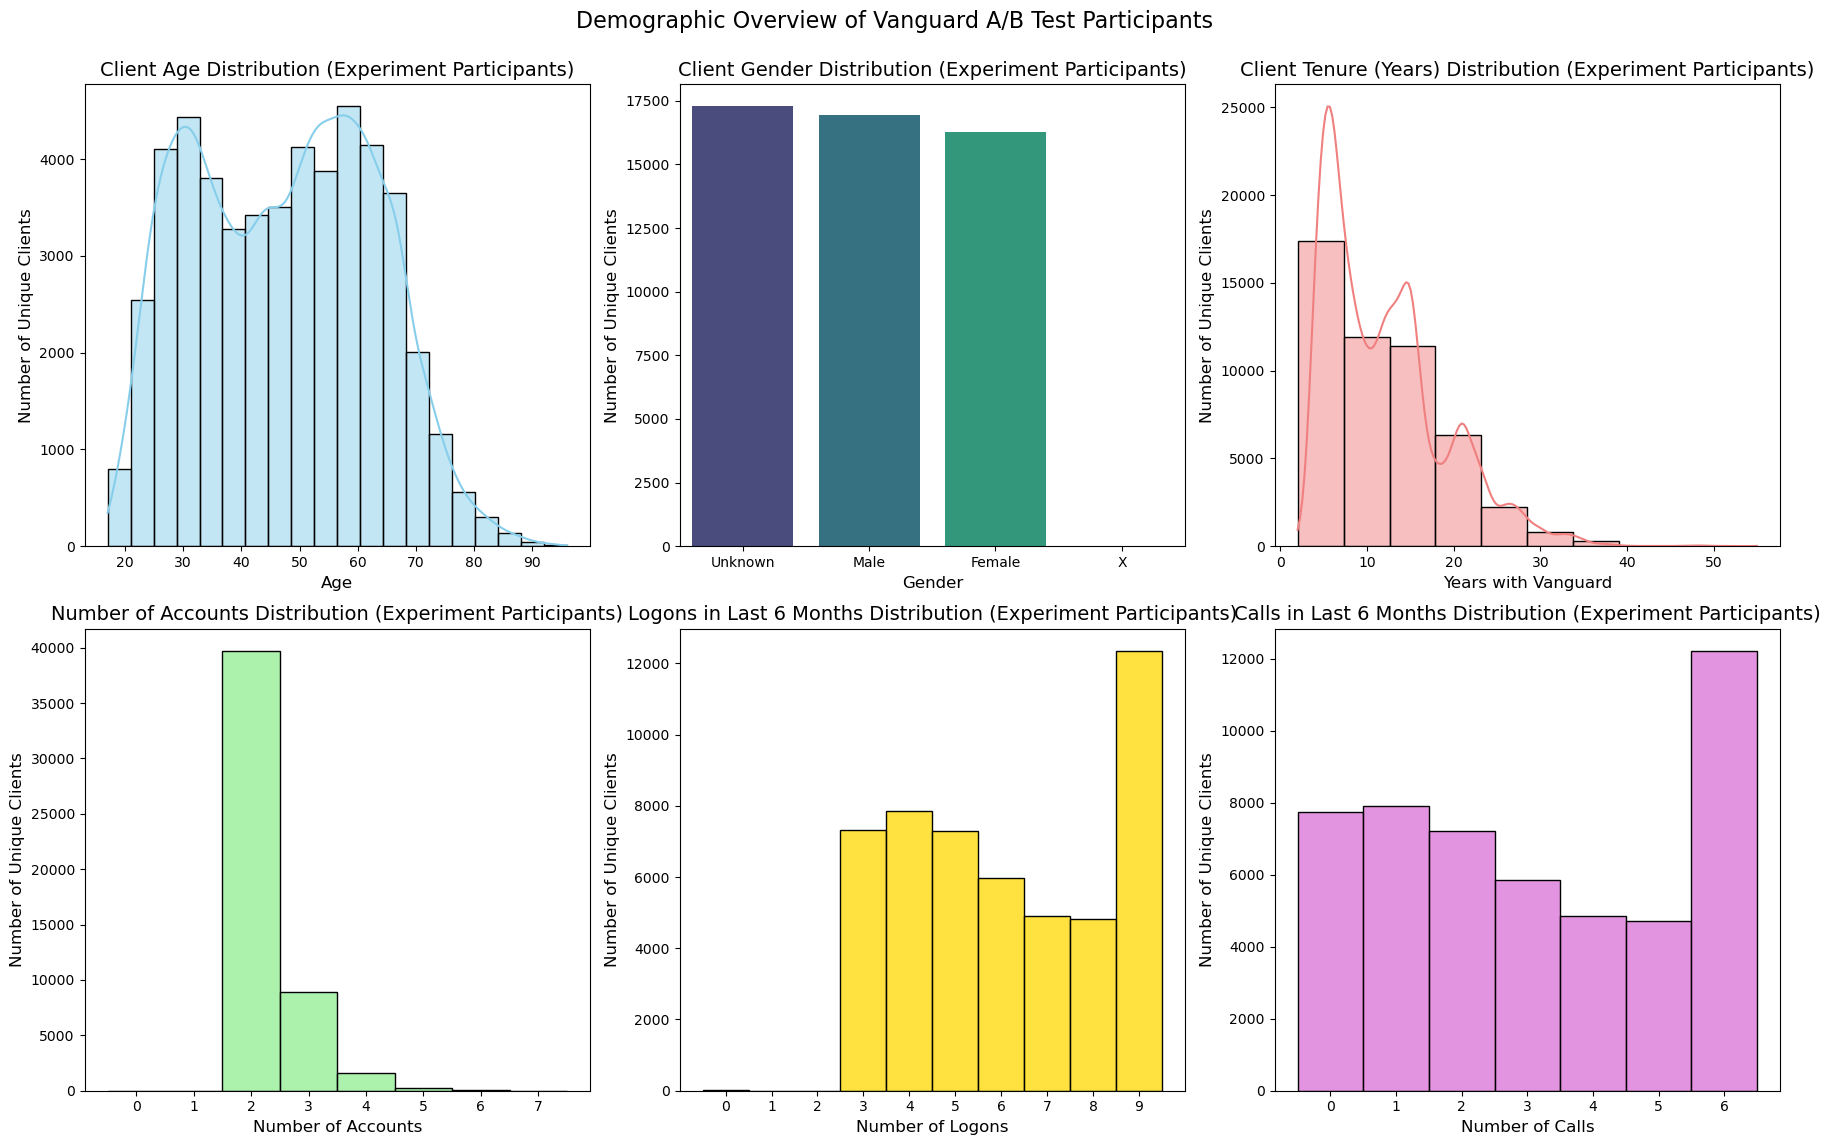


Descriptive statistics for key demographics (Unique Clients in Experiment):
           clnt_age  clnt_tenure_yr     num_accts           bal  calls_6_mnth  logons_6_mnth
count  50487.000000    50487.000000  50500.000000  5.048700e+04  50500.000000   50500.000000
mean      47.319795       12.031810      2.254000  1.495168e+05      3.092475       6.130277
std       15.518616        6.860326      0.534831  3.020390e+05      2.188290       2.177384
min       17.000000        2.000000      0.000000  2.378944e+04      0.000000       0.000000
25%       33.500000        6.000000      2.000000  3.987718e+04      1.000000       4.000000
50%       48.000000       11.000000      2.000000  6.573433e+04      3.000000       6.000000
75%       59.500000       16.000000      2.000000  1.399583e+05      5.000000       8.000000
max       96.000000       55.000000      7.000000  1.632004e+07      6.000000       9.000000

Mode of Gender: Unknown

-- Age and Tenure Insights (Experiment Participants) --
Aver

C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_54660\927566786.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gendr', y='logons_6_mnth', data=unique_clients_df, palette='pastel')


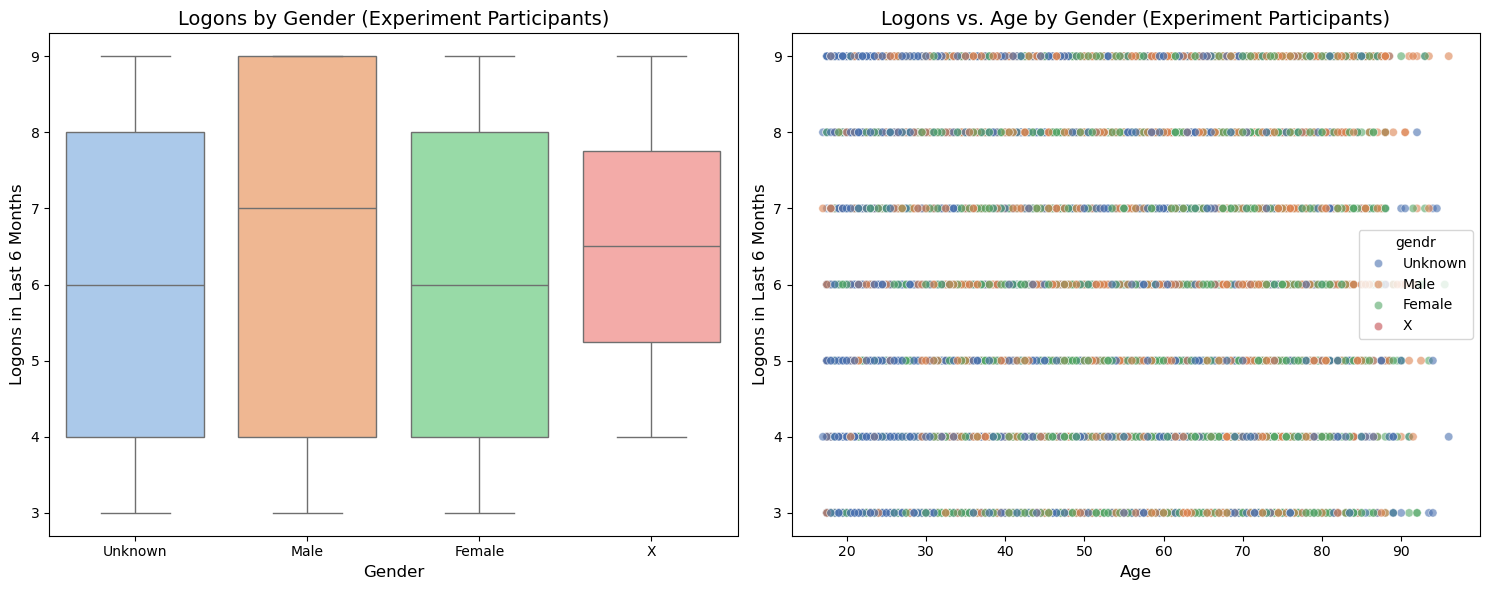

C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_54660\927566786.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='num_accts', y='bal', data=unique_clients_df, palette='coolwarm')


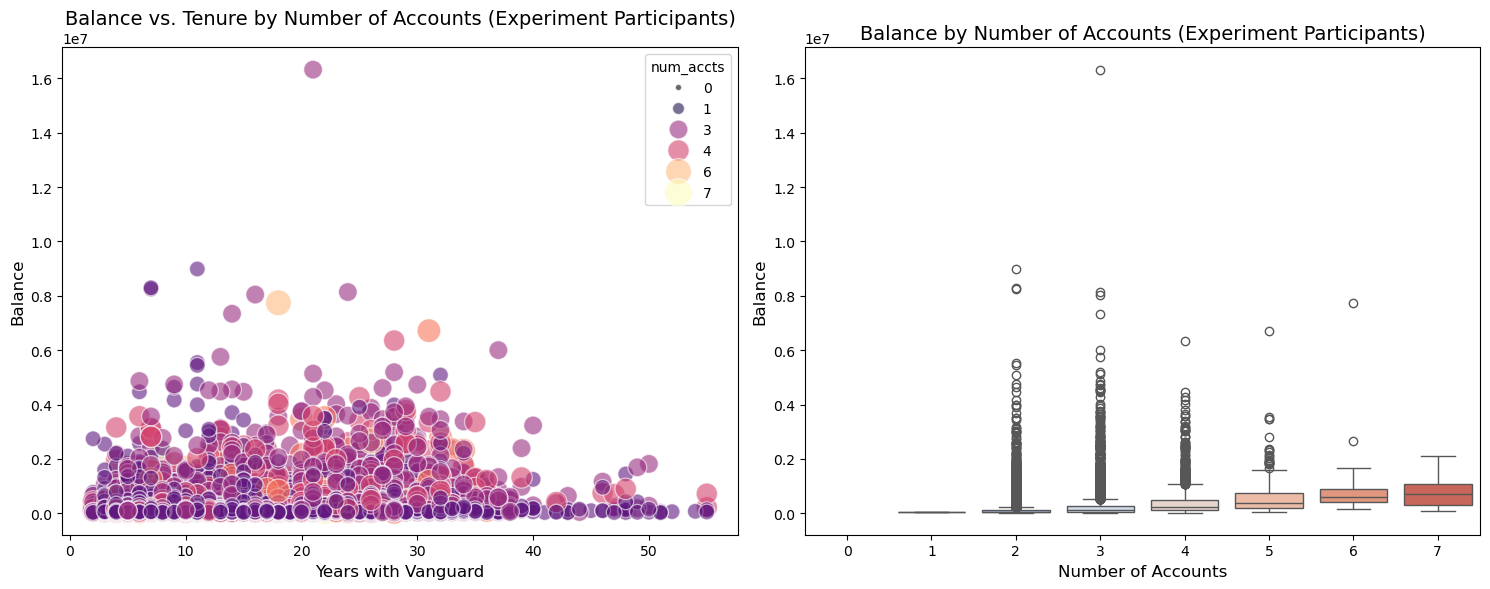


Distribution of Process Steps (Overall in Experiment):
process_step
start      0.305254
step_1     0.219252
step_2     0.181751
step_3     0.155699
confirm    0.138044
Name: proportion, dtype: float64


In [60]:
# --- Now, the Initial EDA ---
# EDA runs on the prepared df_full_ab_test.


print("\n--- Client Behavior Analysis (EDA) on Cleaned & Merged Data (df_full_ab_test) ---")

# Ensure we're using unique client_ids for demographic analysis to avoid bias from multiple web events per client.
unique_clients_df = df_full_ab_test.drop_duplicates(subset=['client_id']).copy()

# --- FIX FOR VALUEERROR: NaN in X-axis Ticks ---
# Check for NaNs in 'logons_6_mnth' and 'calls_6_mnth'
print("\nChecking and cleaning 'logons_6_mnth' and 'calls_6_mnth' for plotting...")
print("NaNs in 'logons_6_mnth' before cleaning:", unique_clients_df['logons_6_mnth'].isnull().sum())
print("NaNs in 'calls_6_mnth' before cleaning:", unique_clients_df['calls_6_mnth'].isnull().sum())

# Fill NaNs with 0 (since missing logons/calls means 0 for a client) and convert to integer
unique_clients_df['logons_6_mnth'] = unique_clients_df['logons_6_mnth'].fillna(0).astype(int)
unique_clients_df['calls_6_mnth'] = unique_clients_df['calls_6_mnth'].fillna(0).astype(int)

print("NaNs in 'logons_6_mnth' after cleaning:", unique_clients_df['logons_6_mnth'].isnull().sum())
print("NaNs in 'calls_6_mnth' after cleaning:", unique_clients_df['calls_6_mnth'].isnull().sum())

# Check if `num_accts` might have NaNs
print("NaNs in 'num_accts' before cleaning:", unique_clients_df['num_accts'].isnull().sum())
unique_clients_df['num_accts'] = unique_clients_df['num_accts'].fillna(0).astype(int)
print("NaNs in 'num_accts' after cleaning:", unique_clients_df['num_accts'].isnull().sum())
# --------------------------------------------------

# 1. Who are the primary clients using this online process?
# Overall demographics of clients present in the dataset (those who used the online process AND were in experiment)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
sns.histplot(unique_clients_df['clnt_age'], bins=20, kde=True, color='skyblue')
plt.title('Client Age Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

plt.subplot(2, 3, 2)
# FutureWarning: Passing `palette` without assigning `hue` is deprecated...
# To fix the warning: sns.countplot(x='gendr', data=unique_clients_df, palette='viridis', hue='gendr', legend=False)
sns.countplot(x='gendr', data=unique_clients_df, palette='viridis')
plt.title('Client Gender Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

plt.subplot(2, 3, 3)
sns.histplot(unique_clients_df['clnt_tenure_yr'], bins=10, kde=True, color='lightcoral')
plt.title('Client Tenure (Years) Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Years with Vanguard', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)

plt.subplot(2, 3, 4)
# Ensure bins are correctly set for integer counts
sns.histplot(unique_clients_df['num_accts'], bins=np.arange(unique_clients_df['num_accts'].min(), unique_clients_df['num_accts'].max() + 2) - 0.5, stat='count', color='lightgreen')
plt.title('Number of Accounts Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Number of Accounts', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)
plt.xticks(np.arange(unique_clients_df['num_accts'].min(), unique_clients_df['num_accts'].max() + 1))


plt.subplot(2, 3, 5)
# Ensure bins are correctly set for integer counts
sns.histplot(unique_clients_df['logons_6_mnth'], bins=np.arange(unique_clients_df['logons_6_mnth'].min(), unique_clients_df['logons_6_mnth'].max() + 2) - 0.5, kde=False, color='gold')
plt.title('Logons in Last 6 Months Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Number of Logons', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)
plt.xticks(np.arange(unique_clients_df['logons_6_mnth'].min(), unique_clients_df['logons_6_mnth'].max() + 1))


plt.subplot(2, 3, 6)
# Ensure bins are correctly set for integer counts
sns.histplot(unique_clients_df['calls_6_mnth'], bins=np.arange(unique_clients_df['calls_6_mnth'].min(), unique_clients_df['calls_6_mnth'].max() + 2) - 0.5, kde=False, color='orchid')
plt.title('Calls in Last 6 Months Distribution (Experiment Participants)', fontsize=14)
plt.xlabel('Number of Calls', fontsize=12)
plt.ylabel('Number of Unique Clients', fontsize=12)
plt.xticks(np.arange(unique_clients_df['calls_6_mnth'].min(), unique_clients_df['calls_6_mnth'].max() + 1))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Demographic Overview of Vanguard A/B Test Participants', fontsize=16, y=0.98)
plt.show()

print("\nDescriptive statistics for key demographics (Unique Clients in Experiment):")
print(unique_clients_df[['clnt_age', 'clnt_tenure_yr', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']].describe())
print("\nMode of Gender:", unique_clients_df['gendr'].mode()[0])


# 2. Are the primary clients younger or older, new or long-standing?
print("\n-- Age and Tenure Insights (Experiment Participants) --")
avg_age = unique_clients_df['clnt_age'].mean()
median_age = unique_clients_df['clnt_age'].median()
avg_tenure_yr = unique_clients_df['clnt_tenure_yr'].mean()
median_tenure_yr = unique_clients_df['clnt_tenure_yr'].median()

print(f"Average client age: {avg_age:.2f} years, Median age: {median_age:.2f} years")
print(f"Average client tenure: {avg_tenure_yr:.2f} years, Median tenure: {median_tenure_yr:.2f} years")

if median_age < 35:
    age_desc = "relatively young"
elif median_age >=35 and median_age < 55:
    age_desc = "middle-aged"
else:
    age_desc = "older"

if median_tenure_yr < 5:
    tenure_desc = "newer"
elif median_tenure_yr >= 5 and median_tenure_yr < 15:
    tenure_desc = "established"
else:
    tenure_desc = "long-standing"

print(f"Interpretation: Primary clients in the experiment are typically {age_desc} and {tenure_desc}.")


# 3. Client behavior analysis (additional relevant questions)
print("\n-- Additional Client Behavior Insights (Experiment Participants) --")

# How does logon frequency vary by age and gender?
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='gendr', y='logons_6_mnth', data=unique_clients_df, palette='pastel')
plt.title('Logons by Gender (Experiment Participants)', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Logons in Last 6 Months', fontsize=12)

plt.subplot(1, 2, 2)
sns.scatterplot(x='clnt_age', y='logons_6_mnth', data=unique_clients_df, alpha=0.6, hue='gendr', palette='deep')
plt.title('Logons vs. Age by Gender (Experiment Participants)', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Logons in Last 6 Months', fontsize=12)
plt.tight_layout()
plt.show()

# How does balance vary by tenure and number of accounts?
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x='clnt_tenure_yr', y='bal', data=unique_clients_df, alpha=0.6, hue='num_accts', palette='magma', size='num_accts', sizes=(20, 400))
plt.title('Balance vs. Tenure by Number of Accounts (Experiment Participants)', fontsize=14)
plt.xlabel('Years with Vanguard', fontsize=12)
plt.ylabel('Balance', fontsize=12)

plt.subplot(1, 2, 2)
sns.boxplot(x='num_accts', y='bal', data=unique_clients_df, palette='coolwarm')
plt.title('Balance by Number of Accounts (Experiment Participants)', fontsize=14)
plt.xlabel('Number of Accounts', fontsize=12)
plt.ylabel('Balance', fontsize=12)
plt.tight_layout()
plt.show()

# Distribution of process steps in general (before A/B split analysis)
print("\nDistribution of Process Steps (Overall in Experiment):")
print(df_full_ab_test['process_step'].value_counts(normalize=True))

DataFrame 'df_full_ab_test_cleaned.csv' loaded successfully from: C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed\df_full_ab_test_cleaned.csv
Shape of the DataFrame: (302289, 18)

--- Client Age Group Distribution by Variation (Percentage) ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_18328\2287295571.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = df_full_ab_test_cleaned.groupby(['age_group_band', 'variation']).size().unstack(fill_value=0)


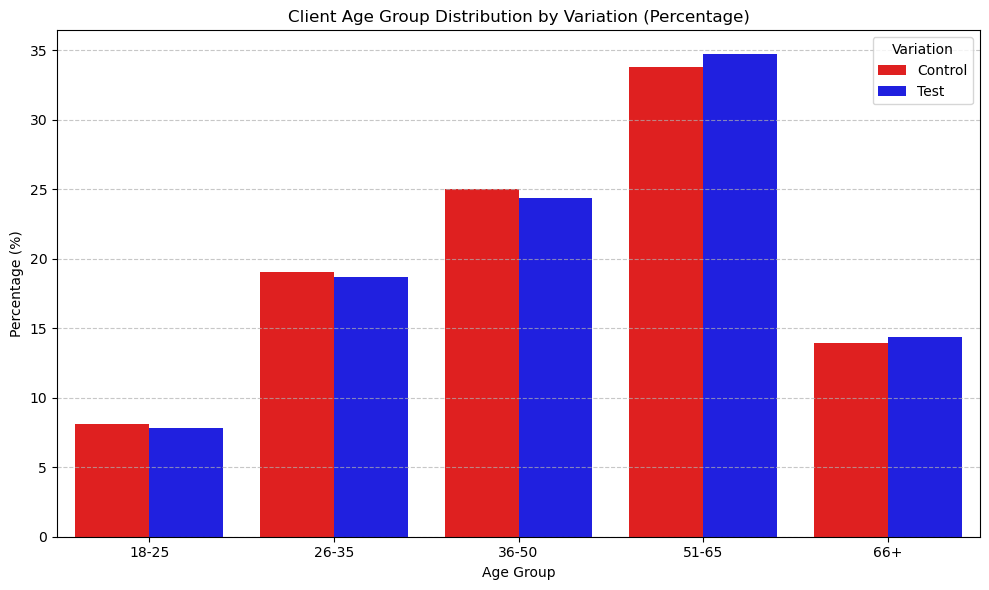

Chart for Client Age Group Distribution by Variation (Percentage) generated.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module for path operations

# --- Data Loading Section ---
# Define the path where the processed data is saved
processed_data_path = r'C:\Users\Mahmoud Gobran\00_Ironhack\Projects\vanguard-ab-test\data\processed'
input_file_name = 'df_full_ab_test_cleaned.csv'
input_full_path = os.path.join(processed_data_path, input_file_name)

# Load the full_ab_test_cleaned.csv file into a DataFrame
df_full_ab_test_cleaned = pd.read_csv(input_full_path)

print(f"DataFrame '{input_file_name}' loaded successfully from: {input_full_path}")
print(f"Shape of the DataFrame: {df_full_ab_test_cleaned.shape}")
# ----------------------------


# --- Chart 1: Client Age Group Distribution by Variation (Percentage) ---

print("\n--- Client Age Group Distribution by Variation (Percentage) ---")

# Ensure 'Clnt Age' is treated as categorical for correct binning/grouping
# We'll re-bin it to match the provided Tableau bins (e.g., 18-25, 26-35, etc.)
# First, let's create age bands similar to Tableau's binning if not already present

# Define the bins and labels for age groups
# Using df_full_ab_test_cleaned['Clnt Age'].max() + 1 to ensure the highest age is included
age_bins = [18, 26, 36, 51, 66, df_full_ab_test_cleaned['clnt_age'].max() + 1]
age_labels = ['18-25', '26-35', '36-50', '51-65', '66+']

# Create the 'age_group_band' column based on the defined bins
df_full_ab_test_cleaned['age_group_band'] = pd.cut(
    df_full_ab_test_cleaned['clnt_age'],
    bins=age_bins,
    labels=age_labels,
    right=False, # Make bins [min, max) to align with typical age ranges
    include_lowest=True
)

# Calculate the counts for each age band and variation
age_distribution = df_full_ab_test_cleaned.groupby(['age_group_band', 'variation']).size().unstack(fill_value=0)

# Calculate the percentage within each Variation (Control and Test)
age_distribution_percentage = age_distribution.apply(lambda x: x / x.sum() * 100, axis=0)

# Reset index to make 'age_group_band' a column for plotting
age_distribution_percentage = age_distribution_percentage.reset_index()

# Melt the DataFrame to long format for Seaborn plotting
age_distribution_percentage_melted = age_distribution_percentage.melt(
    id_vars='age_group_band',
    var_name='Variation',
    value_name='Percentage'
)

# Ensure the age_group_band order is maintained for plotting
age_distribution_percentage_melted['age_group_band'] = pd.Categorical(
    age_distribution_percentage_melted['age_group_band'],
    categories=age_labels,
    ordered=True
)

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=age_distribution_percentage_melted,
    x='age_group_band',
    y='Percentage',
    hue='Variation',
    palette={'Control': 'red', 'Test': 'blue'} # Matching your Tableau colors
)

plt.title('Client Age Group Distribution by Variation (Percentage)')
plt.xlabel('Age Group')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

print("Chart for Client Age Group Distribution by Variation (Percentage) generated.")


--- Balance Group Distribution by Variation (Percentage) ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_18328\2640312147.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_distribution = df_full_ab_test_cleaned.groupby(['balance_group_band', 'variation']).size().unstack(fill_value=0)


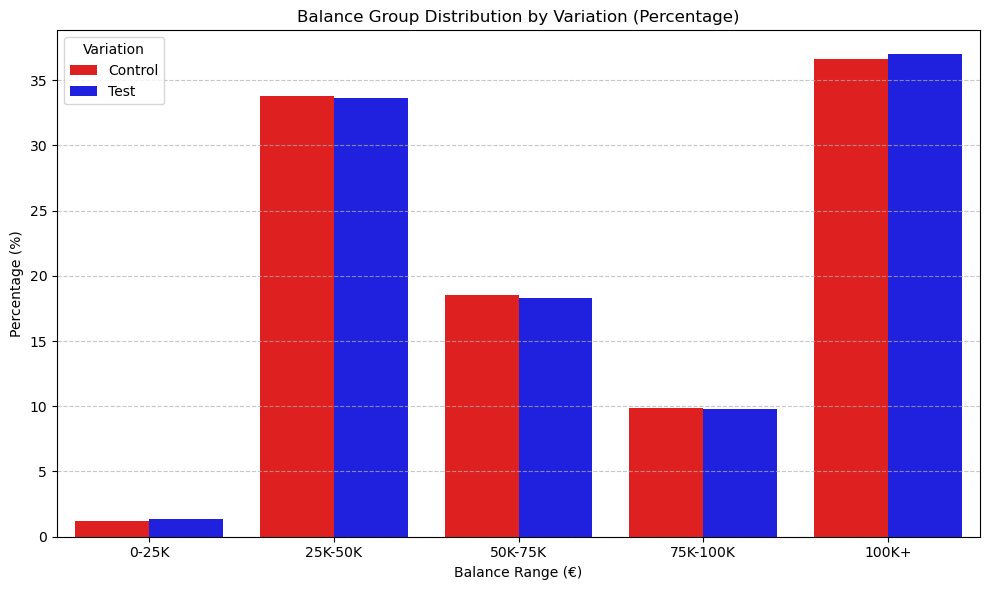

Chart for Balance Group Distribution by Variation (Percentage) generated.


In [20]:
# --- Chart 2: Balance Group Distribution by Variation (Percentage) ---

print("\n--- Balance Group Distribution by Variation (Percentage) ---")

# Define the bins and labels for Balance Ranges based on your image
# Assuming 'Bal' is the column name for Balance
balance_bins = [0, 25000, 50000, 75000, 100000, df_full_ab_test_cleaned['bal'].max() + 1]
balance_labels = ['0-25K', '25K-50K', '50K-75K', '75K-100K', '100K+']

# Create the 'balance_group_band' column
df_full_ab_test_cleaned['balance_group_band'] = pd.cut(
    df_full_ab_test_cleaned['bal'],
    bins=balance_bins,
    labels=balance_labels,
    right=False, # Make bins [min, max)
    include_lowest=True
)

# Calculate the counts for each balance band and variation
balance_distribution = df_full_ab_test_cleaned.groupby(['balance_group_band', 'variation']).size().unstack(fill_value=0)

# Calculate the percentage within each Variation (Control and Test)
balance_distribution_percentage = balance_distribution.apply(lambda x: x / x.sum() * 100, axis=0)

# Reset index to make 'balance_group_band' a column for plotting
balance_distribution_percentage = balance_distribution_percentage.reset_index()

# Melt the DataFrame to long format for Seaborn plotting
balance_distribution_percentage_melted = balance_distribution_percentage.melt(
    id_vars='balance_group_band',
    var_name='Variation',
    value_name='Percentage'
)

# Ensure the balance_group_band order is maintained for plotting
balance_distribution_percentage_melted['balance_group_band'] = pd.Categorical(
    balance_distribution_percentage_melted['balance_group_band'],
    categories=balance_labels,
    ordered=True
)

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=balance_distribution_percentage_melted,
    x='balance_group_band',
    y='Percentage',
    hue='Variation',
    palette={'Control': 'red', 'Test': 'blue'} # Matching your Tableau colors
)

plt.title('Balance Group Distribution by Variation (Percentage)')
plt.xlabel('Balance Range (€)')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

print("Chart for Balance Group Distribution by Variation (Percentage) generated.")


--- Logons in Last 6 Months Distribution by Variation (Percentage) ---


C:\Users\Mahmoud Gobran\AppData\Local\Temp\ipykernel_18328\1970160541.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  logons_distribution = df_full_ab_test_cleaned.groupby(['logons_group_band', 'variation']).size().unstack(fill_value=0)


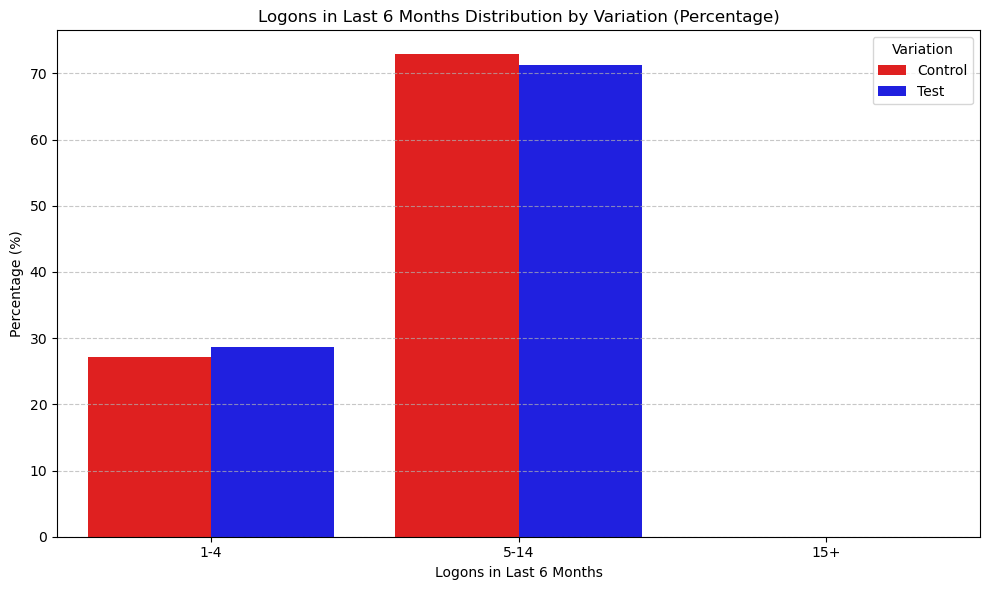

Chart for Logons in Last 6 Months Distribution by Variation (Percentage) generated.


In [ ]:
# --- Chart 3: Logons in Last 6 Months Distribution by Variation (Percentage) ---

print("\n--- Logons in Last 6 Months Distribution by Variation (Percentage) ---")

# Define the bins and labels for Logons in Last 6 Months 
max_logons = df_full_ab_test_cleaned['logons_6_mnth'].max()

# Ensure the last bin includes all values up to the maximum found in the data
final_bin_upper_bound = max(16, max_logons + 1) # Ensure it's at least 16, or max_logons + 1 if higher

logons_bins = [0, 5, 15, final_bin_upper_bound]
logons_labels = ['1-4', '5-14', '15+']

# Create the 'logons_group_band' column
df_full_ab_test_cleaned['logons_group_band'] = pd.cut(
    df_full_ab_test_cleaned['logons_6_mnth'],
    bins=logons_bins,
    labels=logons_labels,
    right=False, # Make bins [min, max)
    include_lowest=True
)

# Calculate the counts for each logons band and variation
logons_distribution = df_full_ab_test_cleaned.groupby(['logons_group_band', 'variation']).size().unstack(fill_value=0)

# Calculate the percentage within each Variation (Control and Test)
logons_distribution_percentage = logons_distribution.apply(lambda x: x / x.sum() * 100, axis=0)

# Reset index to make 'logons_group_band' a column for plotting
logons_distribution_percentage = logons_distribution_percentage.reset_index()

# Melt the DataFrame to long format for Seaborn plotting
logons_distribution_percentage_melted = logons_distribution_percentage.melt(
    id_vars='logons_group_band',
    var_name='Variation',
    value_name='Percentage'
)

# Ensure the logons_group_band order is maintained for plotting
logons_distribution_percentage_melted['logons_group_band'] = pd.Categorical(
    logons_distribution_percentage_melted['logons_group_band'],
    categories=logons_labels,
    ordered=True
)

# Plotting the grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=logons_distribution_percentage_melted,
    x='logons_group_band',
    y='Percentage',
    hue='Variation',
    palette={'Control': 'red', 'Test': 'blue'} # Matching your Tableau colors
)

plt.title('Logons in Last 6 Months Distribution by Variation (Percentage)')
plt.xlabel('Logons in Last 6 Months')
plt.ylabel('Percentage (%)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

print("Chart for Logons in Last 6 Months Distribution by Variation (Percentage) generated.")
